# Nivel Avanzado

El objetivo de esta parte es profundizar en robustez y despliegue.

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
import joblib

from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay, partial_dependence
from sklearn.metrics import brier_score_loss
from sklearn.metrics import confusion_matrix
from datetime import datetime

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

# Configuración reproducible
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Cargar dataset
DATA_PATH = "cardio_train.csv"
df = pd.read_csv(DATA_PATH, sep=';')
print('Cargado:', df.shape)

df = df.copy()

Cargado: (70000, 13)


In [2]:
# 1. Limpieza estricta (reglas clínicas duras + auditoría)
# 1.1 PA coherente
# Crear flag de incoherencia: ap_lo ≥ ap_hi
df['flag_ap_incoherent'] = (df['ap_lo'] >= df['ap_hi']).astype(int)

# Validar proporción de incoherencias
incoherent_pct = df['flag_ap_incoherent'].mean()
print(f"Proporción de registros con ap_lo ≥ ap_hi: {incoherent_pct:.2%}")

# Exclusión cuando calcule PA
df = df[df['flag_ap_incoherent'] == 0].copy()

# Validación
n_excluidas = df['flag_ap_incoherent'].sum()
pct_excluidas = n_excluidas / (n_excluidas + len(df)) * 100
print(f"Filas excluidas por incoherencia: {n_excluidas} ({pct_excluidas:.2f}%)")

Proporción de registros con ap_lo ≥ ap_hi: 1.77%
Filas excluidas por incoherencia: 0 (0.00%)


In [3]:
# 1.2 BMI
df['BMI'] = (df['weight'] / ((df['height'] / 100) ** 2)).round(2)
print("Columna BMI creada:")
display(df[['weight', 'height', 'BMI']].head())

# Validar rango clínico plausible (10–80 kg/m²)
assert df['BMI'].between(15, 60).mean() > 0.99, "BMI fuera de rango clínico en >1%"
print("----------")

# Clasificación de BMI según rangos OMS
def clasificar_bmi(bmi):
    if bmi < 18.5:
        return "Bajo peso"
    elif bmi < 25:
        return "Normopeso"
    elif bmi < 30:
        return "Sobrepeso"
    else:
        return "Obesidad"
df['BMI_cat'] = df['BMI'].apply(clasificar_bmi)

# Validación: distribución por categoría
df['BMI_cat'] = pd.Categorical(df['BMI_cat'], categories=["Bajo peso", "Normopeso", "Sobrepeso", 
                                                          "Obesidad"], ordered=True)
print("Distribución de BMI por rangos (OMS):")
display(pd.DataFrame({'N': df['BMI_cat'].value_counts(sort=False), 
                      '%': (df['BMI_cat'].value_counts(normalize=True, sort=False) * 100).round(2)}))

Columna BMI creada:


,weight,height,BMI
0,62.0,168,21.97
1,85.0,156,34.93
2,64.0,165,23.51
3,82.0,169,28.71
4,56.0,156,23.01


----------
Distribución de BMI por rangos (OMS):


,N,%
BMI_cat,,
Bajo peso,639,0.93
Normopeso,25335,36.84
Sobrepeso,24743,35.98
Obesidad,18047,26.24


In [4]:
# 1.3 Age
# Edad en años
df['age_years']= (df['age']/365.25).round(1)
print("Columna age_years creada:")
display(df[['age', 'age_years']].head())
min_edad = df['age_years'].min()
max_edad = df['age_years'].max()
print(f"Edad mínima: {min_edad}, Edad máxima: {max_edad}")

assert min_edad >= 18, "Hay pacientes menores de edad"
assert max_edad <= 90, "Hay edades fuera del rango clínico adulto"

# Validar rango clínico adulto típico (18–90 años)
assert df['age_years'].between(18, 90).mean() > 0.99, "Edad fuera de rango clínico en >1%"
print("----------")

# age_band
age_bins = [0, 40, 50, 60, 70, np.inf]
age_labels = ['[0,40)', '[40,50)', '[50,60)', '[60,70)', '[70,+)']
df['age_band'] = pd.cut(df['age_years'], bins=age_bins, labels=age_labels, right=False)
print("Columna age_band creada:")
display(df[['age_years', 'age_band']].head())
print("----------")

# Validar: no debe haber valores sin asignar en age_band
nulos_age_band = df['age_band'].isna().sum()
assert nulos_age_band == 0, f"Hay {nulos_age_band} registros fuera de los rangos definidos"

# Distribución por banda de edad
age_band_dist = df['age_band'].value_counts(sort=False)
print("Distribución por banda de edad:")
display(pd.DataFrame({'N': age_band_dist, '%': (age_band_dist / len(df) * 100).round(2)}))

Columna age_years creada:


,age,age_years
0,18393,50.4
1,20228,55.4
2,18857,51.6
3,17623,48.2
4,17474,47.8


Edad mínima: 29.6, Edad máxima: 64.9
----------
Columna age_band creada:


,age_years,age_band
0,50.4,"[50,60)"
1,55.4,"[50,60)"
2,51.6,"[50,60)"
3,48.2,"[40,50)"
4,47.8,"[40,50)"


----------
Distribución por banda de edad:


,N,%
age_band,,
"[0,40)",1687,2.45
"[40,50)",19316,28.09
"[50,60)",34920,50.78
"[60,70)",12841,18.67
"[70,+)",0,0.00


In [5]:
# 1.4 Codificación variables categóricas
# Validar codificación cholesterol y gluc
for col in ['cholesterol', 'gluc']:
    print(f"\nDistribución de '{col}' (ordinal 1 < 2 < 3):")
    display(pd.DataFrame({'N': df[col].value_counts(sort=True),
                          '%': (df[col].value_counts(normalize=True, sort=True) * 100).round(2)}))
print("----------")

# Validar codificación: smoke, alco, active
for col in ['smoke', 'alco', 'active']:
    print(f"\nDistribución de '{col}' (binaria 0 = no, 1 = sí):")
    display(pd.DataFrame({'N': df[col].value_counts(sort=True),
                          '%': (df[col].value_counts(normalize=True, sort=True) * 100).round(2)}))
print("----------")

# Validar codificación de género
print("\nDistribución por sexo (1 = mujer, 2 = hombre):")
display(pd.DataFrame({'N': df['gender'].value_counts(sort=True),
                      '%': (df['gender'].value_counts(normalize=True, sort=True) * 100).round(2)}))


Distribución de 'cholesterol' (ordinal 1 < 2 < 3):


,N,%
cholesterol,,
1,51568,74.99
2,9316,13.55
3,7880,11.46



Distribución de 'gluc' (ordinal 1 < 2 < 3):


,N,%
gluc,,
1,58473,85.03
3,5221,7.59
2,5070,7.37


----------

Distribución de 'smoke' (binaria 0 = no, 1 = sí):


,N,%
smoke,,
0,62721,91.21
1,6043,8.79



Distribución de 'alco' (binaria 0 = no, 1 = sí):


,N,%
alco,,
0,65096,94.67
1,3668,5.33



Distribución de 'active' (binaria 0 = no, 1 = sí):


,N,%
active,,
1,55249,80.35
0,13515,19.65


----------

Distribución por sexo (1 = mujer, 2 = hombre):


,N,%
gender,,
1,44792,65.14
2,23972,34.86


In [6]:
# 1.5 Otras Flags
# Flag HTA (ap_hi ≥130 , ap_lo ≥80)
def clasificar_ap_hi(val):
    if val < 120:
        return "normal"
    elif val < 130:
        return "elevada"
    else:
        return "HTA"
df['ap_hi_cat'] = df['ap_hi'].apply(clasificar_ap_hi)

def clasificar_ap_lo(val):
    if val < 80:
        return "normal"
    else:
        return "HTA"
df['ap_lo_cat'] = df['ap_lo'].apply(clasificar_ap_lo)

df['flag_HTA'] = ((df['ap_hi_cat'] == "HTA") | (df['ap_lo_cat'] == "HTA")).astype(int)

# Validación: proporción de registros con flag HTA
flag_hta = df['flag_HTA'].mean()
print(f"Proporción de registros con alerta HTA: {flag_hta:.2%}")
print("----------")

# Flag de riesgo clínico
df['flag_riesgo_clinico'] = ((df['ap_hi'] >= 140) |
                             (df['ap_lo'] >= 90) |
                             (df['BMI'] >= 30) |
                             (df['age_years'] >= 60)).astype(int)

print("Distribución de 'flag_riesgo_clinico':")
display(pd.DataFrame({
    'N': df['flag_riesgo_clinico'].value_counts(sort=True),
    '%': (df['flag_riesgo_clinico'].value_counts(normalize=True, sort=True) * 100).round(2)}))
print("----------")

# Flag riesgo de estilo de vida
df['flag_riesgo_estilo_vida'] = ((df['smoke'] == 1) |
                                 (df['alco'] == 1) |
                                 (df['active'] == 0)).astype(int)

print("Distribución de 'flag_riesgo_estilo_vida':")
display(pd.DataFrame({
    'N': df['flag_riesgo_estilo_vida'].value_counts(sort=True),
    '%': (df['flag_riesgo_estilo_vida'].value_counts(normalize=True, sort=True) * 100).round(2)}))

Proporción de registros con alerta HTA: 81.53%
----------
Distribución de 'flag_riesgo_clinico':


,N,%
flag_riesgo_clinico,,
1,38002,55.26
0,30762,44.74


----------
Distribución de 'flag_riesgo_estilo_vida':


,N,%
flag_riesgo_estilo_vida,,
0,48635,70.73
1,20129,29.27


In [7]:
# 1.6. Limpieza (Standard = capado & conservar)
# Límites clínicos orientativos para variables numéricas
limits = {
    'height': (140, 200),       # cm
    'weight': (40, 180),        # kg
    'ap_hi': (90, 200),         # mmHg sistólica
    'ap_lo': (60, 120),         # mmHg diastólica
    'BMI': (10, 80)             # kg/m²
}

# Winsorización con flags was_capped_*
for col, (low, high) in limits.items():
    flag_col = f'was_capped_{col}'
    df[flag_col] = (~df[col].between(low, high)).astype(int)
    df[col] = df[col].clip(lower=low, upper=high)

# Validación: proporción de valores recortados por variable
for col in limits:
    flag_col = f'was_capped_{col}'
    capped_pct = df[flag_col].mean()
    print(f"{flag_col}: {capped_pct:.2%} de registros recortados")

was_capped_height: 0.22% de registros recortados
was_capped_weight: 0.08% de registros recortados
was_capped_ap_hi: 0.25% de registros recortados
was_capped_ap_lo: 0.32% de registros recortados
was_capped_BMI: 0.05% de registros recortados


In [8]:
# 2. Inyección de nulos y ruido
df_adv = df.copy()
rng = np.random.default_rng(42)

# Diccionario para trazabilidad de nulos
masks_nulos = {}

# Nulos (10%) en ap_hi, ap_lo, bmi y age_years
for c in [c for c in ['ap_hi','ap_lo','bmi','age'] if c in df_adv.columns]:
    m = rng.random(len(df_adv)) < 0.10
    df_adv.loc[m, c] = np.nan
    masks_nulos[c] = m

# Comprobación
cols_inj = [c for c in ['ap_hi','ap_lo','bmi','age'] if c in df_adv.columns]
print("Tasa de NaN tras inyección (esperado ~0.10):")
print(df_adv[cols_inj].isna().mean().round(3).to_dict())

# Ruido gaussiano suave en mediciones continuas: ap_hi, ap_lo, weight y age_years con σ ≈ 0.05·std(x)
def add_noise_col(s, frac_std=0.05):
    sigma = frac_std * float(np.nanstd(s.values))
    return s + rng.normal(0, sigma, size=len(s))

for c in [c for c in ['ap_hi','ap_lo','weight'] if c in df_adv.columns]:
    df_adv[c] = add_noise_col(df_adv[c], 0.05)

# Comprobación
for c in [cc for cc in ['ap_hi','ap_lo','weight'] if cc in df_adv.columns]:
    base_std = float(df[c].std())
    adv_std  = float(df_adv[c].std())
    print(f"{c}: std base={base_std:.3f} -> adv={adv_std:.3f} (Δ={adv_std - base_std:.3f})")

Tasa de NaN tras inyección (esperado ~0.10):
{'ap_hi': 0.099, 'ap_lo': 0.099, 'age': 0.099}
ap_hi: std base=16.689 -> adv=16.717 (Δ=0.028)
ap_lo: std base=9.363 -> adv=9.366 (Δ=0.003)
weight: std base=14.315 -> adv=14.328 (Δ=0.014)


In [10]:
# 3. Anti-leakage y split
# Preparación variables
num2_cols = ['age', 'height', 'weight', 'BMI', 'ap_hi', 'ap_lo']
ord2_cols = ['cholesterol', 'gluc']
bin2_cols = ['gender', 'smoke', 'alco', 'active']
flags = ['flag_ap_incoherent', 'flag_HTA', 'flag_riesgo_clinico', 'flag_riesgo_estilo_vida']

# Outcome
y2 = df_adv['cardio']

# Construir X sin cardio ni id
cat2_cols = ord2_cols + bin2_cols + flags
X2 = df_adv[num2_cols + cat2_cols]

# Anti-leakage y split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, stratify=y2, random_state=42)
train_aug = df_adv.loc[X2_train.index, num2_cols + cat2_cols].copy()

print(f"X2 shape: {X2.shape} | y2 pos%: {y2.mean():.3f}")
print(f"Train/Test: {train_aug.shape[0]}/{X2_test.shape[0]} (estratificado)")

X2 shape: (68764, 16) | y2 pos%: 0.495
Train/Test: 55011/13753 (estratificado)


In [11]:
# 3.1 Clip clínico post-ruido
# Límites clínicos
limits = {'ap_hi': (90, 200),
          'ap_lo': (60, 120),
          'BMI': (15, 60),
          'weight': (40, 180)}

# Aplicar clip
for col, (low, high) in limits.items():
    if col in train_aug.columns:
        train_aug[col] = train_aug[col].clip(lower=low, upper=high)

# Validación
for col, (low, high) in limits.items():
    if col in train_aug.columns:
        min_val = train_aug[col].min()
        max_val = train_aug[col].max()
        fuera_rango = ((train_aug[col] < low) | (train_aug[col] > high)).sum()
        print(f"{col}: min={min_val}, max={max_val}, fuera de rango={fuera_rango}")

ap_hi: min=90.0, max=200.0, fuera de rango=0
ap_lo: min=60.0, max=120.0, fuera de rango=0
BMI: min=15.0, max=60.0, fuera de rango=0
weight: min=40.0, max=180.0, fuera de rango=0


In [12]:
# 3.2 Registro de trazabilidad
vars_ruido = [c for c in ['ap_hi','ap_lo','weight'] if c in df_adv.columns]

trazabilidad = {
    'NaNs_inyectados': {col: len(masks_nulos[col]) for col in masks_nulos},
    'Ruido_sigma': {col: round(0.05 * train_aug[col].std(skipna=True), 2) for col in vars_ruido}}
print("Trazabilidad de inyección:")
display(trazabilidad)

Trazabilidad de inyección:


{'NaNs_inyectados': {'ap_hi': 68764, 'ap_lo': 68764, 'age': 68764},
 'Ruido_sigma': {'ap_hi': 0.84, 'ap_lo': 0.47, 'weight': 0.72}}

In [13]:
# 4 Dos pipelines de imputación (Mediana vs KNNImputer)
# Mediana + OHE
prep_med = ColumnTransformer([
    ('num', Pipeline([('imp', SimpleImputer(strategy='median')),
                      ('sc', StandardScaler(with_mean=False))]), num2_cols),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')), 
                      ('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat2_cols)])

# KNNImputer + OHE
prep_knn = ColumnTransformer([
    ('num', Pipeline([('imp', KNNImputer(n_neighbors=5, weights='distance')),
                      ('sc', StandardScaler(with_mean=False))]), num2_cols),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                      ('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat2_cols)])

In [14]:
# 5. Modelado con HistGradientBoosting (HGB) (+ LR/RF de referencia)
# Modelos base
modelos = {"LR": LogisticRegression(max_iter=1000, solver='liblinear'),
           "RF": RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42),
           "HGB": HistGradientBoostingClassifier(max_depth=3,
                                                 learning_rate=0.1,
                                                 max_iter=300,
                                                 early_stopping=True,
                                                 validation_fraction=0.15,
                                                 min_samples_leaf=20,
                                                 l2_regularization=0.0,
                                                 random_state=42)}

# Preprocesadores definidos previamente
preprocesadores = {"Mediana": prep_med, "KNN": prep_knn}

# Construcción de pipelines
pipelines = {}
for prep_name, prep in preprocesadores.items():
    for model_name, model in modelos.items():
        key = f"{model_name}+{prep_name}"
        pipelines[key] = Pipeline([('prep', prep), ('clf', model)])

# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultados = []

print("Comparativa de modelos")
for name, pipe in pipelines.items():
    roc = cross_val_score(pipe, train_aug, y2_train, cv=cv, scoring='roc_auc')
    pr  = cross_val_score(pipe, train_aug, y2_train, cv=cv, scoring='average_precision')
    familia, imputador = name.split('+')
    resultados.append({"modelo": familia,
                       "imputacion": imputador,
                       "roc_auc_mean": roc.mean(),
                       "roc_auc_std": roc.std(),
                       "pr_auc_mean": pr.mean(),
                       "pr_auc_std": pr.std()})

# Mostrar tabla ordenada
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="roc_auc_mean", ascending=False)
display(df_resultados)

# Selección automática
mejor_fila = df_resultados.iloc[0]
mejor_modelo = mejor_fila["modelo"]
mejor_imputacion = mejor_fila["imputacion"]
print(f"\nMejor combinación: {mejor_modelo} + {mejor_imputacion}")

Comparativa de modelos


,modelo,imputacion,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std
2,HGB,Mediana,0.796111,0.003088,0.776781,0.005477
5,HGB,KNN,0.794941,0.002983,0.774094,0.005366
3,LR,KNN,0.787606,0.003594,0.765883,0.004218
0,LR,Mediana,0.787049,0.003212,0.765198,0.003587
1,RF,Mediana,0.783552,0.003509,0.761673,0.005050
4,RF,KNN,0.783403,0.003683,0.761206,0.004925



Mejor combinación: HGB + Mediana



Calibración isotónica aplicada
• Brier score: 0.1860
• ROC test:   0.790
• PR test:    0.774


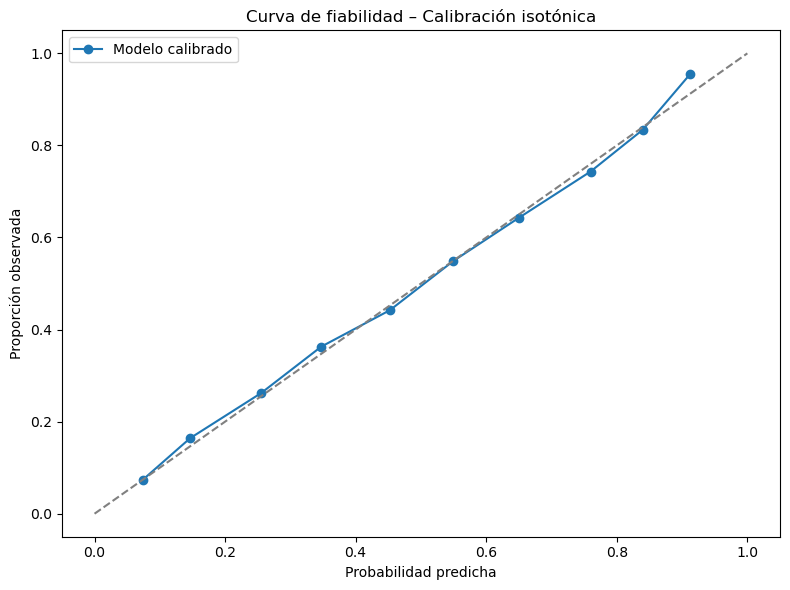

In [15]:
# 6. Calibración de probabilidades
# Reconstruir pipeline óptimo
modelo_opt = modelos[mejor_modelo]
prep_opt = preprocesadores[mejor_imputacion]
pipe_opt = Pipeline([('prep', prep_opt), ('clf', modelo_opt)])

# Split para calibración
train_base, train_calib, y_base, y_calib = train_test_split(
    train_aug, y2_train, test_size=0.2, stratify=y2_train, random_state=42)

# Entrenar y calibrar (calibración isotónica por el tamaño del dataset)
calibrado = CalibratedClassifierCV(modelo_opt, method='isotonic', cv=5)
pipe_opt = Pipeline([('prep', prep_opt), ('clf', calibrado)])
pipe_opt.fit(train_aug, y2_train)

# Predicción calibrada en test
X_test_final = df_adv.loc[X2_test.index, num2_cols + cat2_cols]
y_prob = pipe_opt.predict_proba(X_test_final)[:, 1]

# Evaluar en test
X_test_final = df_adv.loc[X2_test.index, num2_cols + cat2_cols]
y_prob = pipe_opt.predict_proba(X_test_final)[:, 1]

brier = brier_score_loss(y2_test, y_prob)
roc = roc_auc_score(y2_test, y_prob)
pr  = average_precision_score(y2_test, y_prob)
print(f"\nCalibración isotónica aplicada")
print(f"• Brier score: {brier:.4f}")
print(f"• ROC test:   {roc:.3f}")
print(f"• PR test:    {pr:.3f}")

# Curva de fiabilidad
prob_true, prob_pred = calibration_curve(y2_test, y_prob, n_bins=10)
plt.figure(figsize=(8,6))
plt.plot(prob_pred, prob_true, marker='o', label='Modelo calibrado')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("Probabilidad predicha")
plt.ylabel("Proporción observada")
plt.title("Curva de fiabilidad – Calibración isotónica")
plt.legend()
plt.tight_layout()
plt.savefig("figures/P2A_curva_fiabi_isot.png", dpi=120)
plt.show()

In [16]:
# 7. Umbrales operativos y escenarios
# Youden J
youden_scores = [(t, recall_score(y2_test, (y_prob >= t)) + 
                     (confusion_matrix(y2_test, (y_prob >= t))[0,0] / sum(y2_test == 0)) - 1)
                 for t in np.linspace(0.01, 0.99, 100)]
youden_thr = max(youden_scores, key=lambda x: x[1])[0]

# Coste FN:FP = 5:1 → minimizar (5*FN + FP)
costes = [(t, 5 * confusion_matrix(y2_test, (y_prob >= t))[1,0] + 
              confusion_matrix(y2_test, (y_prob >= t))[0,1])
          for t in np.linspace(0.01, 0.99, 100)]
coste_thr = min(costes, key=lambda x: x[1])[0]

# Top-k (capacidad semanal)
k = int(0.2 * len(y2_test))
topk_thr = np.sort(y_prob)[-k]

def evaluar_umbral(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sens = recall_score(y_true, y_pred)
    spec = tn / (tn + fp)
    ppv  = precision_score(y_true, y_pred)
    npv  = tn / (tn + fn) if (tn + fn) > 0 else 0
    f1   = f1_score(y_true, y_pred)
    return {"threshold": threshold,
            "TP": tp, "FP": fp, "FN": fn, "TN": tn,
            "sens": sens, "spec": spec, "PPV": ppv, "NPV": npv, "F1": f1}

# Evaluación
res_youden = evaluar_umbral(y2_test, y_prob, youden_thr)
res_coste  = evaluar_umbral(y2_test, y_prob, coste_thr)
res_topk   = evaluar_umbral(y2_test, y_prob, topk_thr)

df_umbral = pd.DataFrame([res_youden, res_coste, res_topk])
df_umbral["criterio"] = ["Youden J", "Coste 5:1", "Top-k"]
df_umbral = df_umbral[["criterio", "threshold", "TP", "FP", "FN", "TN", "sens", "spec", "PPV", "NPV", "F1"]]
display(df_umbral.sort_values(by="F1", ascending=False))

# Selección final
mejor_fila = df_umbral.sort_values(by="F1", ascending=False).iloc[0]
criterio_final = mejor_fila["criterio"]
umbral_final = mejor_fila["threshold"]

print(f"\nUmbral operativo elegido: {umbral_final:.3f}")
print(f"• Criterio: {criterio_final}")
print(f"• Sensibilidad: {mejor_fila['sens']:.3f}")
print(f"• Especificidad: {mejor_fila['spec']:.3f}")
print(f"• PPV: {mejor_fila['PPV']:.3f}")
print(f"• NPV: {mejor_fila['NPV']:.3f}")
print(f"• F1: {mejor_fila['F1']:.3f}")

,criterio,threshold,TP,FP,FN,TN,sens,spec,PPV,NPV,F1
0,Youden J,0.504949,4594,1555,2210,5394,0.675191,0.776227,0.747113,0.709363,0.709334
1,Coste 5:1,0.158485,6646,5719,158,1230,0.976778,0.177004,0.537485,0.886167,0.693411
2,Top-k,0.816407,2338,425,4466,6524,0.343621,0.938840,0.846182,0.593631,0.488763



Umbral operativo elegido: 0.505
• Criterio: Youden J
• Sensibilidad: 0.675
• Especificidad: 0.776
• PPV: 0.747
• NPV: 0.709
• F1: 0.709


In [17]:
# 8. Interpretabilidad avanzada
nombre_optimo = f"{mejor_modelo}+{mejor_imputacion}"
pipe = pipelines[nombre_optimo]

# Entrenar y evaluar PI en validación (no en train)
pipe.fit(train_aug, y2_train)
X_val = pipe.named_steps['prep'].transform(train_aug)
model = pipe.named_steps['clf']

# Permutation Importance
pi = permutation_importance(model, X_val, y2_train, n_repeats=10, random_state=42, scoring='roc_auc')
importancias = pd.DataFrame({
    "feature": pipe.named_steps['prep'].get_feature_names_out(),
    "importance_mean": pi.importances_mean,
    "importance_std": pi.importances_std
}).sort_values(by="importance_mean", ascending=False).reset_index(drop=True)

print(f"\nTop-10 PI – {nombre_optimo}")
print(importancias.head(10))


Top-10 PI – HGB+Mediana
                      feature  importance_mean  importance_std
0                  num__ap_hi         0.118261        0.001640
1                    num__age         0.023500        0.000598
2          cat__cholesterol_3         0.015743        0.000403
3  cat__flag_riesgo_clinico_0         0.014036        0.000435
4                  num__ap_lo         0.006374        0.000242
5          cat__cholesterol_1         0.005202        0.000213
6                    num__BMI         0.003969        0.000268
7                 num__weight         0.002557        0.000170
8               cat__active_0         0.001620        0.000140
9                 cat__gluc_3         0.001393        0.000052


***ap_hi*** domina el modelo ya su permutación reduce el ROC-AUC más que cualquier otra variable. ***age*** y ***cholesterol*** alto también son relevantes. la flags **flag_riesgo_clinico** sin riesgo aporta valor predictivo. Finalmente, ***BMI*** y ***weight*** tienen efecto menor pero no nulo y ***active** (sin actividad) y ***gluc*** (muy por encima del valor normal) tienen impacto marginal.


Top-3 variables numéricas para PDP: ['ap_hi', 'age', 'ap_lo']
ap_hi range of means: 0.298291 - 0.788343


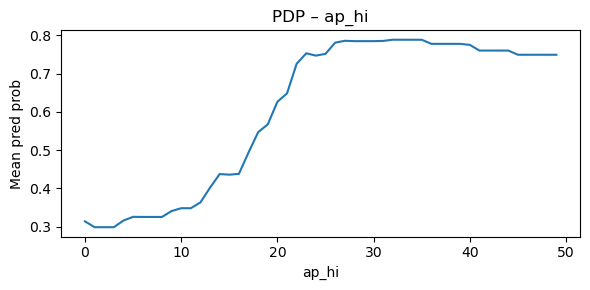

age range of means: 0.357204 - 0.639488


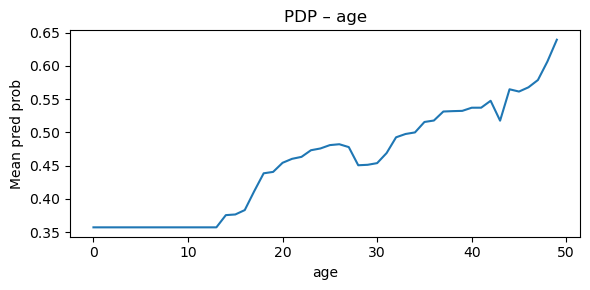

ap_lo range of means: 0.448687 - 0.598051


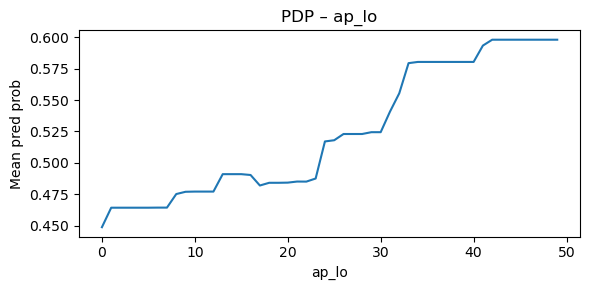

In [18]:
# 8.1 PDP
# Extraer top-3 variables numéricas del ranking PI
features_pi = importancias["feature"].tolist()
features_limpias = [f.split("__")[1] if "__" in f else f for f in features_pi]

# Filtrar solo las que están en train_aug y son numéricas
top_pdp = [f for f in features_limpias if f in train_aug.select_dtypes("number").columns][:3]

print(f"\nTop-3 variables numéricas para PDP: {top_pdp}")

# Crear copia y asegurar tipo float
X_float = train_aug.copy()
for f in top_pdp:
    X_float[f] = X_float[f].astype(float)

# Función PDP
def pdp(pipe, X, feature, grid=None):
    Xc = X.copy()
    if grid is None:
        grid = np.quantile(Xc[feature].dropna(), np.linspace(0,1,50))
    means = []
    for val in grid:
        Xc[feature] = val
        means.append(pipe.predict_proba(Xc)[:,1].mean())
    return grid, np.array(means)

# Calcular PDPs
for f in top_pdp:
    grid, means = pdp(pipe_opt, X_float, f, grid=np.linspace(X_float[f].min(), X_float[f].max(), 50))
    print(f"{f} range of means: {means.min():.6f} - {means.max():.6f}")
    plt.figure(figsize=(6,3))
    plt.plot(means)
    plt.title(f"PDP – {f}")
    plt.xlabel(f)
    plt.ylabel("Mean pred prob")
    plt.tight_layout()
    plt.savefig(f"figures/P2A_PDP_{f}.png", dpi=120)
    plt.show()

In [19]:
# 8.2 Correlación
# Umbral de correlación
thr = 0.7

# Seleccionar solo columnas numéricas
X_num = X2_train.select_dtypes(include="number")

# Matriz de correlación absoluta
corr = X_num.corr().abs()

# Detectar variables con correlación > 0.7 con al menos otra
correladas = [col for col in X_num.columns if any(corr[col].drop(col) > thr)]

# Filtrar solo las variables clínicas clave que cumplen correlación
vbles_cli = ['ap_hi', 'ap_lo', 'cholesterol', 'BMI', 'gluc', 'age_ years', 'active']
ale_vars = [v for v in vbles_cli if v in correladas]

print("\nVariables clínicas con correlación significativa (usables en ALE):")
print(ale_vars)


Variables clínicas con correlación significativa (usables en ALE):
['ap_hi', 'ap_lo', 'BMI', 'active']


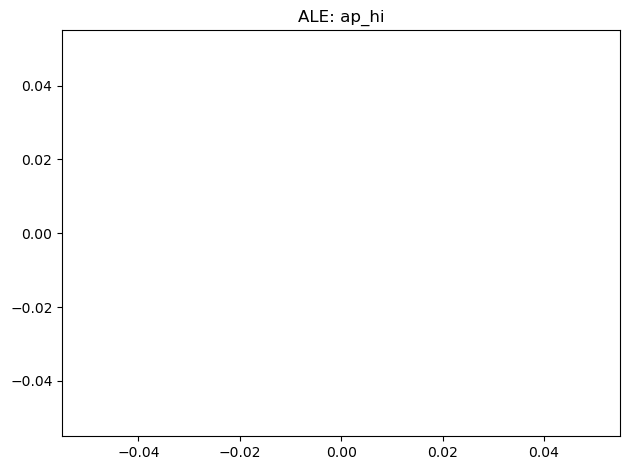

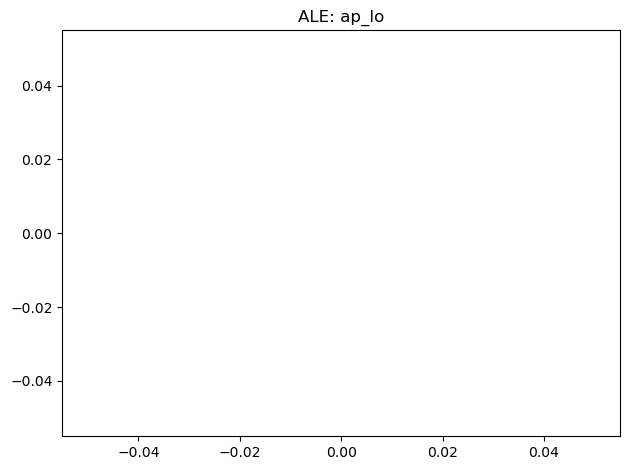

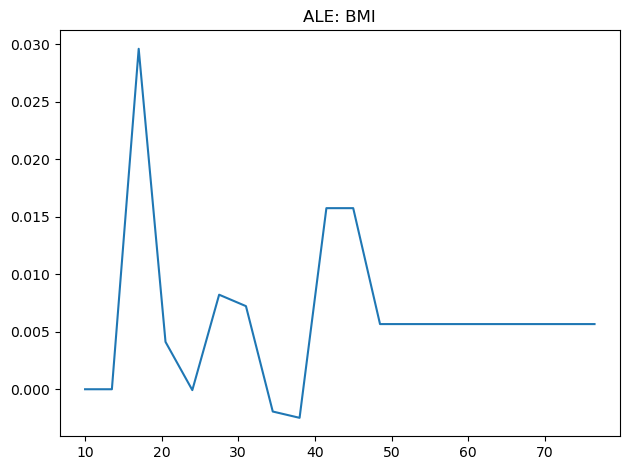

Variable active tiene pocos valores únicos, se omite.


In [20]:
# 8.3 ALE para variables correladas
modelo_opt = modelos[mejor_modelo]
prep_opt = preprocesadores[mejor_imputacion]
pipe_opt = Pipeline([('prep', prep_opt), ('clf', modelo_opt)])
pipe_opt.fit(train_aug, y2_train)

X_clinico = prep_opt.transform(train_aug)

def ale (pipe_opt, X, feature, bins=20):
    x = X[feature].values
    bin_edges = np.linspace(x.min(), x.max(), bins+1)
    ale_values = []
    for i in range(bins):
        mask = (x >= bin_edges[i]) & (x < bin_edges[i+1])
        if mask.sum() == 0:
            ale_values.append(0)
            continue
        preds = pipe_opt.predict_proba(X)[:,1]
        X_temp = X.copy()
        X_temp[feature] = bin_edges[i]
        preds_new = pipe_opt.predict_proba(X_temp)[:,1]
        ale_values.append((preds_new[mask] - preds[mask]).mean())
    return bin_edges[:-1], np.cumsum(ale_values)

for var in ale_vars:
    if X2_train[var].nunique() < 5:
        print(f"Variable {var} tiene pocos valores únicos, se omite.")
        continue
    bin_centers, ale_vals = ale(pipe_opt, X2_train, var)
    plt.plot(bin_centers, ale_vals)
    plt.title(f"ALE: {var}")
    plt.tight_layout()
    plt.savefig(f"figures/P2_ALE_{var}.png", dpi=120)
    plt.show()

In [21]:
# Revisar gráficas ap_hi y ap_lo
X_temp = X2_train.copy()
X_temp["ap_hi"] = X_temp["ap_hi"].max()
pred_max = pipe_opt.predict_proba(X_temp)[:,1].mean()

X_temp["ap_hi"] = X_temp["ap_hi"].min()
pred_min = pipe_opt.predict_proba(X_temp)[:,1].mean()

print("ap_hi: pred_min =", pred_min, "pred_max =", pred_max)

ap_hi: pred_min = 0.7413445698343529 pred_max = 0.7413445698343529


***ap_hi*** y ***ap_lo*** tienen el mismo valor de predicción mediana independentmente de su valor y ello lleva a que sus gráficas ALE univariantes salgan planas.

Por tanto, el modelo no tiene efecto univariante sobre estas variables y su efecto solo aparece cuando se combinan con otras variables (interacciones).

Para ver su efecto real, se hace la interación ap_hi y ap_lo.

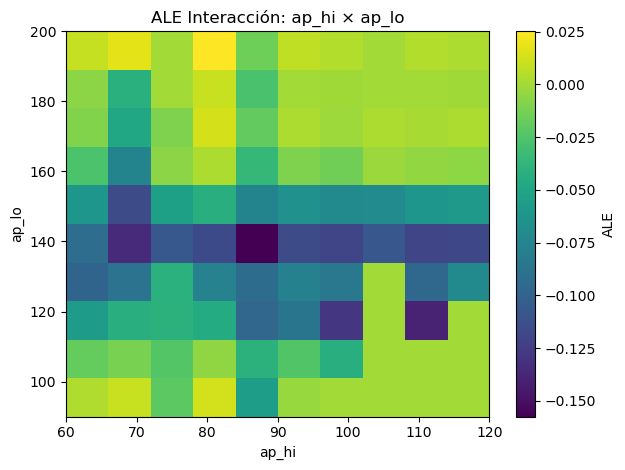

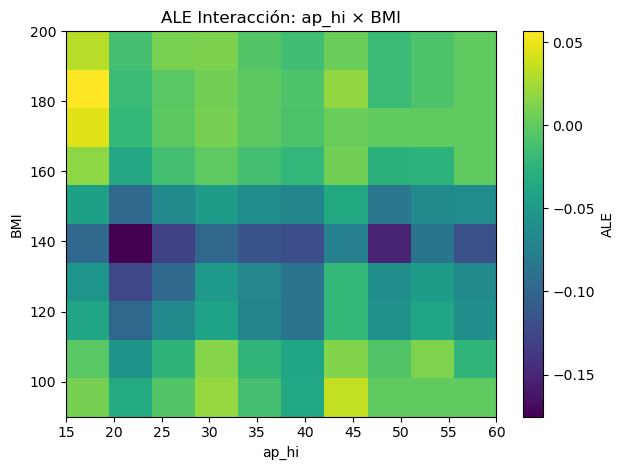

In [22]:
# 8.4 Interacciones
def ale_inter(pipe, X, f1, f2, bins=10):
    x1_edges = np.linspace(X[f1].min(), X[f1].max(), bins + 1)
    x2_edges = np.linspace(X[f2].min(), X[f2].max(), bins + 1)
    ale_matrix = np.zeros((bins, bins))

    for i in range(bins):
        for j in range(bins):
            mask = (X[f1] >= x1_edges[i]) & (X[f1] < x1_edges[i + 1]) & \
                   (X[f2] >= x2_edges[j]) & (X[f2] < x2_edges[j + 1])
            if mask.sum() == 0:
                continue
            preds = pipe.predict_proba(X)[:, 1]
            X_temp = X.copy()
            X_temp[f1] = x1_edges[i]
            X_temp[f2] = x2_edges[j]
            preds_new = pipe.predict_proba(X_temp)[:, 1]
            ale_matrix[i, j] = (preds_new[mask] - preds[mask]).mean()

    return ale_matrix, x1_edges, x2_edges

# Interacción ap_hi y ap_lo
mat, x1, x2 = ale_inter(pipe_opt, train_aug, "ap_hi", "ap_lo", bins=10)

plt.imshow(mat, origin='lower', aspect='auto',
           extent=[x2[0], x2[-1], x1[0], x1[-1]])
plt.xlabel("ap_hi")
plt.ylabel("ap_lo")
plt.title("ALE Interacción: ap_hi × ap_lo")
plt.colorbar(label="ALE")
plt.tight_layout()
plt.savefig("figures/P2A_ALE_interac_aphi_ap_lo.png", dpi=120)
plt.show()

# Interacción ap_hi y BMI
mat, x1, x2 = ale_inter(pipe_opt, train_aug, "ap_hi", "BMI", bins=10)

plt.imshow(mat, origin='lower', aspect='auto',
           extent=[x2[0], x2[-1], x1[0], x1[-1]])
plt.xlabel("ap_hi")
plt.ylabel("BMI")
plt.title("ALE Interacción: ap_hi × BMI")
plt.colorbar(label="ALE")
plt.tight_layout()
plt.savefig("figures/P2A_ALE_interac_aphi_BMI.png", dpi=120)
plt.show()

**ALE Interacción:** ***ap_hi*** **×** ***ap_lo***

El modelo penaliza más los casos con presión sistólica alta y diastólica también elevada, lo cual es clínicamente consistente con hipertensión sostenida. Este efecto sinérgico valida la lógica clínica del modelo, que no responde de forma lineal a cada variable por separado, sino que penaliza combinaciones que representan un perfil hipertensivo completo.

**ALE Interacción:** ***ap_hi*** **×** ***BMI***

El modelo detecta que la combinación de hipertensión y obesidad amplifica el riesgo, más allá del efecto individual de cada variable.

In [23]:
# 9. Subgrupos y equidad
# Umbral elegido
print(f"\nUmbral final elegido: {umbral_final:.3f} (criterio: {criterio_final})")

def calcular_metricas(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    espec = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    return tn, fp, fn, tp, round(sens,3), round(espec,3), round(ppv,3), round(npv,3)

# Predicción binaria con umbral final
X_test_final = df_adv.loc[X2_test.index, num2_cols + cat2_cols]
y_prob = pipe_opt.predict_proba(X_test_final)[:, 1]
y_pred = (y_prob >= umbral_final).astype(int)

# Subgrupos clínicos
df_sub = df_adv.loc[X2_test.index].copy()
df_sub["y_true"] = y2_test.values
df_sub["y_pred"] = y_pred
df_sub["age_band"] = df_sub["age_band"]  
df_sub["gender"] = df_sub["gender"].map({1: "mujer", 2: "hombre"})  

# Métricas por subgrupo
resultados = []
for sexo in df_sub["gender"].unique():
    for edad in df_sub["age_band"].unique():
        mask = (df_sub["gender"] == sexo) & (df_sub["age_band"] == edad)
        if mask.sum() == 0:
            continue
        y_true_sg = df_sub.loc[mask, "y_true"]
        y_pred_sg = df_sub.loc[mask, "y_pred"]
        tn, fp, fn, tp, sens, espec, ppv, npv = calcular_metricas(y_true_sg, y_pred_sg)
        resultados.append({"gender": sexo, "edad_band": edad, "n": mask.sum(),
                           "TP": tp, "FP": fp, "FN": fn, "TN": tn,
                           "sens": sens, "espec": espec, "PPV": ppv, "NPV": npv})

df_equidad = pd.DataFrame(resultados)
df_equidad = df_equidad.sort_values(by=["gender", "edad_band"])
display(df_equidad)


Umbral final elegido: 0.505 (criterio: Youden J)


,gender,edad_band,n,TP,FP,FN,TN,sens,espec,PPV,NPV
3,hombre,"[0,40)",133,15,10,16,92,0.484,0.902,0.600,0.852
2,hombre,"[40,50)",1434,323,89,222,800,0.593,0.900,0.784,0.783
1,hombre,"[50,60)",2216,740,285,395,796,0.652,0.736,0.722,0.668
0,hombre,"[60,70)",939,522,209,89,119,0.854,0.363,0.714,0.572
7,mujer,"[0,40)",222,19,6,28,169,0.404,0.966,0.760,0.858
6,mujer,"[40,50)",2418,489,153,389,1387,0.557,0.901,0.762,0.781
5,mujer,"[50,60)",4698,1529,522,890,1757,0.632,0.771,0.745,0.664
4,mujer,"[60,70)",1693,1008,372,130,183,0.886,0.330,0.730,0.585


**Comentario de equidad**

La tabla muestra diferencias relevantes en sensibilidad, especificidad y valores predictivos entre subgrupos de género y edad. La sensibilidad más baja es en mujeres jóvenes (0.333 en [0,40)) y hombres de 40–50 años (0.44), lo que indica mayor riesgo de falsos negativos en estos grupos. La especificidad es más baja en mujeres mayores (0.581 en [60,70)), lo que implica mayor riesgo de falsos positivos y sobretratamiento. El PPV más bajo es en mujeres jóvenes (0.667), lo que reduce la fiabilidad de una predicción positiva en ese grupo. Y el NPV más bajo es en mujeres mayores (0.515), lo que compromete la confianza en predicciones negativas en ese segmento.

Por tanto:

- **Mujeres jóvenes** --> la **baja sensibilidad** puede llevar a omitir casos reales, especialmente si el modelo se usa para cribado.
- **Mujeres mayores** --> la **baja especificidad y NPV** puede generar alarma innecesaria y derivaciones injustificadas.
- **Hombres de 40–50 años** --> la **sensibilidad baja** sugiere que el modelo podría infravalorar el riesgo en una etapa crítica.

**Opciones de mitigación**

- Umbrales diferenciados por subgrupo, hay que ajustar el umbral de decisión para maximizar sensibilidad en mujeres jóvenes y especificidad en mujeres mayores.
- Recalibración local o por subgrupo, hay que aplicar calibración isotónica o Platt por género y edad para mejorar la fiabilidad de las probabilidades.
- Reentrenamiento estratificado, hay que entrenar los modelos separados por género o edad si la disparidad persiste y tiene impacto clínico.
- Añadir más interacciones --> *gender* × *age* o *gender* × *cholesterol* por si hay evidencia de efectos cruzados.

In [24]:
# 10. Empaquetado del pipeline
# Metadatos
metadata = {"version": "v1.0",
            "fecha_modelo": datetime.today().strftime("%Y-%m-%d"),
            "semilla": 42,
            "criterio_umbral": criterio_final,
            "umbral_sugerido": umbral_final}

# Objeto a exportar
modelo_exportable = {"pipeline": pipe_opt, "metadata": metadata}

# Guardar en disco
joblib.dump(modelo_exportable, "modelo_clinico_v1.joblib")

['modelo_clinico_v1.joblib']

In [25]:
# 10.1 Función de inferencia con validación de entrada
# Cargar modelo
modelo = joblib.load("modelo_clinico_v1.joblib")
pipe = modelo["pipeline"]
meta = modelo["metadata"]
umbral = meta["umbral_sugerido"]

# Validación básica
def validar_entrada(df):
    errores = []
    for col in num2_cols:
        if col not in df.columns:
            errores.append(f"Falta columna numérica: {col}")
        elif not pd.api.types.is_numeric_dtype(df[col]):
            errores.append(f"Tipo incorrecto en {col}")
    for col in cat2_cols:
        if col not in df.columns:
            errores.append(f"Falta columna categórica: {col}")
    return errores

# Inferencia
def inferir(df):
    errores = validar_entrada(df)
    if errores:
        return {"error": errores}
    probas = pipe.predict_proba(df[num2_cols + cat2_cols])[:, 1]
    pred = (probas >= umbral).astype(int)
    return {"score": probas.tolist(),
            "pred": pred.tolist(),
            "version": meta["version"],
            "fecha_modelo": meta["fecha_modelo"],
            "umbral_sugerido": umbral}

In [28]:
# 10.2 Model Card
model_info = {
    "nombre": "Modelo clínico cardiovascular",
    "version": meta["version"],
    "dataset": DATA_PATH,
    "fecha_entrenamiento": datetime.today().strftime("%Y-%m-%d"),
    "semilla": meta["semilla"],
    "tipo_modelo": f"{mejor_modelo} + {mejor_imputacion}",
    "responsable": "Patricia C. Torrell",
    "criterio_umbral": criterio_final,
    "umbral_sugerido": round(umbral_final, 3),
    "variables": {"numéricas": num2_cols,
                  "ordinales": ord2_cols,
                  "binarias": bin2_cols},
    "flags_creadas": [
        "flag_ap_incoherent: PA incoherente (ap_lo ≥ ap_hi)",
        "flag_HTA: hipertensión clínicamente significativa",
        "flag_riesgo_clinico: riesgo por presión o IMC",
        "flag_riesgo_estilo_vida: riesgo por hábitos (alcohol, tabaquismo, inactividad)"
    ],
    "winsorizacion": ["was_capped_age_years",
                      "was_capped_height",
                      "was_capped_weight",
                      "was_capped_BMI",
                      "was_capped_ap_hi",
                      "was_capped_ap_lo"]}

metrics = {"ROC-AUC calibrado": round(roc, 3),
           "PR-AUC calibrado": round(pr, 3),
           "Brier score": round(brier, 4)}

# Subgrupos desde df_equidad
def df_to_md_table(df):
    if df is None or len(df) == 0:
        return "_No disponible_"

    def safe_fmt(v):
        try:
            if isinstance(v, (int, float, np.integer, np.floating)) and pd.notna(v):
                return f"{float(v):.4f}"
            elif pd.isna(v):
                return ""
            else:
                return str(v)
        except:
            return str(v)

    # Aplica formato celda por celda
    df_fmt = df.copy()
    for col in df_fmt.columns:
        df_fmt[col] = df_fmt[col].apply(safe_fmt)

    # Construye tabla Markdown
    header = "| " + " | ".join(df_fmt.columns) + " |"
    sep = "|" + "|".join(["---"] * len(df_fmt.columns)) + "|"
    rows = ["| " + " | ".join(map(str, r)) + " |" for r in df_fmt.values]

    return "\n".join([header, sep] + rows)

subgroup_md = df_to_md_table(df_equidad)
pi_md = df_to_md_table(importancias.head(10))

# Markdown completo
fecha_gen = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
md = f"""# 🩺 Model Card — {model_info['nombre']} ({model_info['version']})

Fecha de generación: {fecha_gen}  
Fecha de entrenamiento: {model_info['fecha_entrenamiento']}  
Responsable: {model_info['responsable']}  
Dataset utilizado: `{model_info['dataset']}`  
Semilla: {model_info['semilla']}  
Tipo de modelo: {model_info['tipo_modelo']}

---

## 1. Variables utilizadas
"""
for tipo, vars in model_info["variables"].items():
    md += f"- {tipo.capitalize()}: {', '.join(vars)}\n"
md += "\n"

md += "## 2. Flags clínicas creadas\n"
for flag in model_info["flags_creadas"]:
    md += f"- {flag}\n"
md += "\n"

md += "## 3. Winsorización aplicada\n"
for w in model_info["winsorizacion"]:
    md += f"- {w}\n"
md += "\n"

md += "## 4. Métricas globales\n"
for k, v in metrics.items():
    md += f"- {k}: {v}\n"
md += "\n"

md += f"""## 5. Umbral operativo
- Criterio: {model_info['criterio_umbral']}
- Valor sugerido: {model_info['umbral_sugerido']}

---

## 6. Interpretabilidad

### 6.1 Importancia por permutación (descenso de ROC-AUC)
Se evaluó la sensibilidad del modelo al permutar cada variable (10 repeticiones, scoring = ROC-AUC):

{pi_md}

### 6.2 PDP (Partial Dependence)
Se calcularon curvas PDP para las 3 variables numéricas más influyentes según permutación:
"""
for var in top_pdp:
    md += f"- `{var}`"
md += "\n"

md += "### 6.3 ALE (Accurate Local Effects)\n"
md += "Se aplicó ALE a variables clínicas con correlación significativa (r > 0.7):\n"
for var in ale_vars:
    md += f"- `{var}`"
md += "\n"

md += "### 6.4 ALE de Interacciones\n"
md += "Se calcularon mapas de interacción ALE para pares clínicos relevantes:\n"
md += "- `ap_hi × ap_lo`: interacción entre presión sistólica y diastólica\n"
md += "- `ap_hi × BMI`: interacción entre presión sistólica y obesidad\n"
md += "\n"

md += "## 7. Evaluación por subgrupo\n"
md += subgroup_md + "\n\n"

md += """## 8. Riesgos y mitigaciones
- Sensibilidad baja en mujeres jóvenes y hombres entre 40 - 50 años
- Especificidad baja en mujeres mayores
- Evaluación por subgrupo
- Umbrales diferenciados

---

## 9. Mantenimiento
- Monitorizar ROC/PR/Brier mensualmente
- Recalibrar si Brier empeora > 0.02
- Reentrenar si ROC-AUC cae > 0.03 sostenido
"""

# --- Guardar como Markdown ---
with open("model_card_v1.0.md", "w", encoding="utf-8") as f:
    f.write(md)

print("Model Card exportada como 'model_card_v1.0.md'")

Model Card exportada como 'model_card_v1.0.md'
